In [15]:
# Default locations if parameter not passed
benchmark_data_path = "tb-compare.pkl"

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
import re
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

sns.set_theme()

In [17]:
bench_names = df["name"].unique()
print(f"Benchmarks found: {bench_names}")
run_metadata = benchmark_data["config"].applications
n_runs = benchmark_data["config"].metadata.runs

df_bench = df[df["name"] == 'tb-compare']


n_runs = benchmark_data["config"].metadata.runs
print(f"Number of runs: {n_runs}")
print(df_bench.columns)
print(df_bench.head())


Benchmarks found: ['tb-compare']
Number of runs: 5
Index(['name', 'kernel', 'node_count', 'image', 'ompc_init_iter', 'iter',
       'ompc_resch_iter', 'full_output', 'ompc_tb_iter_num', 'hosts',
       'tb_path', 'type', 'time'],
      dtype='object')
         name         kernel  node_count               image  ompc_init_iter  \
0  tb-compare  compute_bound           2  scheduler-main.sif               5   
1  tb-compare  compute_bound           2  scheduler-main.sif               5   
2  tb-compare  compute_bound           2  scheduler-main.sif               5   
3  tb-compare  compute_bound           2  scheduler-main.sif               5   
4  tb-compare  compute_bound           2  scheduler-main.sif               5   

   iter  ompc_resch_iter                                        full_output  \
0  1000             1000  [1750262761.929178] [sorgan-cpu1:2891290:0]   ...   
1  1000             1000  [1750262769.092291] [sorgan-cpu1:2891414:0]   ...   
2  1000             1000  [175

In [18]:
# tb_time field (seconds)
# get total time from the output
def extract_elapsed_time(text):
    matches = re.findall(r"Elapsed Time ([\d.eE+-]+) seconds", text)
    if matches:
        # gets last mach
        # float() already handles scientific notation
        return float(matches[-1])
    return float('nan')

def extract_total_sched_time(text):
    # Find all "Scheduling : <number>"
    matches = re.findall(r"Scheduling\s*:\s*(\d+)", text)
    if not matches:
        print("No scheduling time found in the text:")
        print(text)
        return None
    total_microseconds = sum(int(m) for m in matches)
    return total_microseconds / 1e6  # microseconds to seconds

def map_schedueler_name(image_name):
    if "improv" in image_name:
        return "Record Replay"
    return "Baseline"

df_bench['tb_time'] = df_bench['full_output'].apply(extract_elapsed_time)
df_bench['sched_time'] = df_bench['full_output'].apply(extract_total_sched_time)
# worker nodes is node_count - 1
df_bench['worker_nodes'] = df_bench['node_count'].apply(lambda x: int(x - 1) if x > 1 else None)
df_bench['scheduler_name'] = df_bench['image'].apply(map_schedueler_name)

print(df_bench.columns)



Index(['name', 'kernel', 'node_count', 'image', 'ompc_init_iter', 'iter',
       'ompc_resch_iter', 'full_output', 'ompc_tb_iter_num', 'hosts',
       'tb_path', 'type', 'time', 'tb_time', 'sched_time', 'worker_nodes',
       'scheduler_name'],
      dtype='object')


# Experiment 1

freeze, for now:
kernel: compute_bound
type: fft

freeze:
ompc_tb_iter_num: 100
ompc_init_iter: 5
ompc_resch_iter: 0

y axsis: tb_time
x axis: worker node count 

one line per iter

Processing iteration: 1000
Processing type: fft


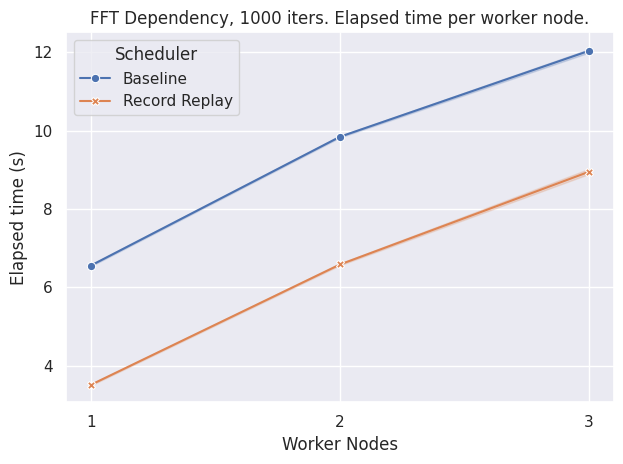

Processing iteration: 1000000
Processing type: fft


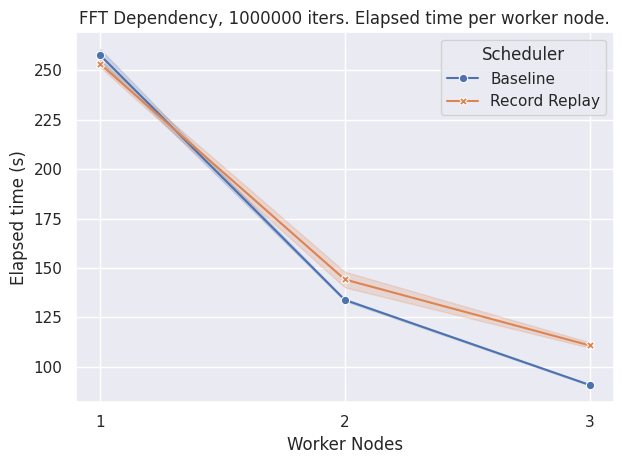

Processing iteration: 2000000
Processing type: fft


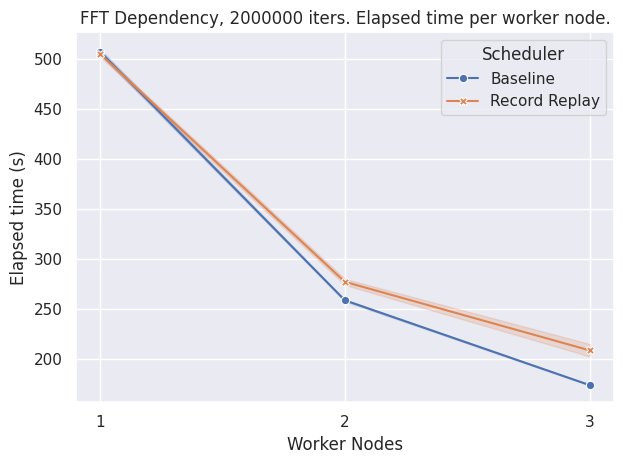

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for iter in df_bench['iter'].unique():
  print(f"Processing iteration: {iter}")
  for type in df_bench['type'].unique():
    print(f"Processing type: {type}")
    ## TODO: keep doing this for kernel and ompc_tb_iter_num

    # apply filter for this loop
    df_plot = df_bench[(df_bench['iter'] == iter) & (df_bench['type'] == type)].copy()
    df_plot = df_plot[['tb_time', 'worker_nodes', 'scheduler_name']].copy()
    df_plot = df_plot.dropna() # worker nodes can be None if np = 1

    # 2) draw the plot
    plt.figure()
    sns.lineplot(
        data=df_plot,
        x='worker_nodes',
        y='tb_time',
        hue='scheduler_name',
        style='scheduler_name',
        markers=True,
        dashes=False,
        errorbar='ci',
    )

    plt.xlabel('Worker Nodes')
    plt.ylabel('Elapsed time (s)')
    plt.title(f'{type.upper()} Dependency, {iter} iters. Elapsed time per worker node.')
    plt.xticks(sorted(df_plot['worker_nodes'].unique()))
    plt.legend(title='Scheduler')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Experiment 2

Show two stacked bars per worker node count.
First stacked bar is: 'Record Replay' scheduler total scheduling stacked over interpolation

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def extract_interpolation_time(text):
  # matchs all interpolation time and return sum of float
  matches = re.findall(r"Interpolation time: ([\d.eE+-]+) seconds", text)

  if matches:
    # Convert all matches to float and sum them up
    total_time = sum(float(match) for match in matches)
    return total_time
  return float('nan')

# 1) Prepare the data: only Record Replay has interpolation
df_bar = df_bench.copy()
df_bar['interp_time'] = 0.0
mask_rr = df_bar['scheduler_name'] == 'Record Replay'
df_bar.loc[mask_rr, 'interp_time'] = df_bar['full_output'].apply(extract_interpolation_time)

df_bar = df_bar[['worker_nodes', 'scheduler_name', 'sched_time', 'interp_time']].copy()
# drop if NaN in worker_nodes
df_bar = df_bar.dropna(subset=['worker_nodes'])
print(df_bar.head(50))


    worker_nodes scheduler_name  sched_time  interp_time
0              1       Baseline    0.672429          0.0
1              1       Baseline    0.685432          0.0
2              1       Baseline    0.667959          0.0
3              1       Baseline    0.691359          0.0
4              1       Baseline    0.682092          0.0
5              1       Baseline    0.692506          0.0
6              1       Baseline    0.666222          0.0
7              1       Baseline    0.667876          0.0
8              1       Baseline    0.676380          0.0
9              1       Baseline    0.678585          0.0
10             1       Baseline    0.688581          0.0
11             1       Baseline    0.677197          0.0
12             1       Baseline    0.683970          0.0
13             1       Baseline    0.662491          0.0
14             1       Baseline    0.702641          0.0
15             2       Baseline    0.774569          0.0
16             2       Baseline

Processing iteration: 1000
Processing type: fft


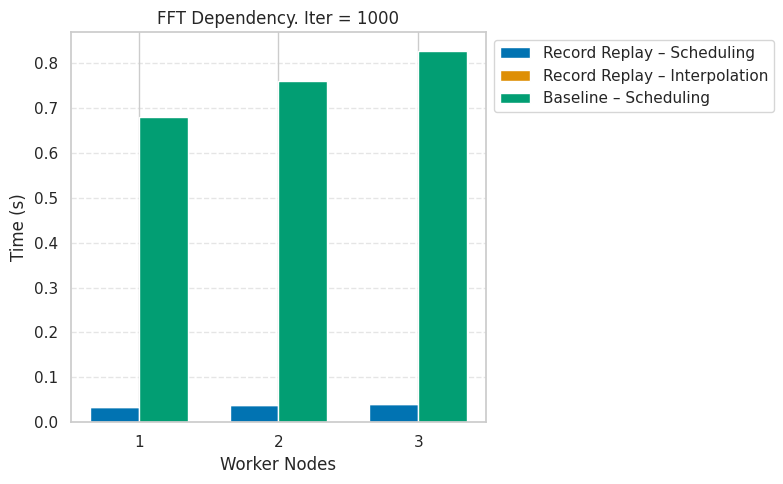

Processing iteration: 1000000
Processing type: fft


/tmp/ipykernel_1283633/2700573099.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bar = df_bar[(df_bench['iter'] == iter) & (df_bench['type'] == type)].copy()


KeyError: "None of [Index(['Record Replay', 'Baseline'], dtype='object', name='scheduler_name')] are in the [columns]"

In [21]:

for iter in df_bench['iter'].unique():
  print(f"Processing iteration: {iter}")
  for type in df_bench['type'].unique():
    print(f"Processing type: {type}")
    ## TODO: keep doing this for kernel and ompc_tb_iter_num

    # apply filter for this loop
    df_bar = df_bar[(df_bench['iter'] == iter) & (df_bench['type'] == type)].copy()
    # 1) Aggregate mean per worker_nodes + scheduler_name
    agg = (
        df_bar
        .groupby(['worker_nodes', 'scheduler_name'])[['sched_time', 'interp_time']]
        .mean()
        .reset_index()
    )

    # 2) Pivot for stacking
    scheduler_order = ['Record Replay', 'Baseline']
    sched = (
        agg
        .pivot(index='worker_nodes', columns='scheduler_name', values='sched_time')
        [scheduler_order]
    )
    interp = (
        agg
        .pivot(index='worker_nodes', columns='scheduler_name', values='interp_time')
        .fillna(0)[scheduler_order]
    )

    # 3) Plot stacked bars side by side, colorblind palette
    nodes = sched.index.values
    x = np.arange(len(nodes))
    width = 0.35
    palette = sns.color_palette("colorblind", 3)

    fig, ax = plt.subplots(figsize=(8, 5))

    # Record Replay: schedule + interpolation
    ax.bar(x, sched['Record Replay'], width,
          label='Record Replay – Scheduling', color=palette[0])
    ax.bar(x, interp['Record Replay'], width,
          bottom=sched['Record Replay'],
          label='Record Replay – Interpolation', color=palette[1])

    # Baseline: scheduling only
    ax.bar(x + width, sched['Baseline'], width,
          label='Baseline – Scheduling', color=palette[2])

    # Formatting
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(nodes)
    ax.set_xlabel("Worker Nodes")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"FFT Dependency. Iter = {iter}")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()